In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [17]:
#Import two datasets
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")
print(train_df.shape)
print(test_df.shape)

#Making the two datasets into one so we can split it up how we want ^_^
full_df = pd.concat([train_df, test_df], ignore_index=True)
print(full_df.shape)

(27455, 785)
(7172, 785)
(34627, 785)


In [18]:
#Split the data into x and y variables
#X = full_df.drop(columns="label")
#y = full_df["label"]

X_train = train_df.drop(columns="label")
y_train = train_df["label"]

X_test = test_df.drop(columns="label")
y_test = test_df["label"]

In [19]:
#Normalize the pixels
X_train = X_train / 255
X_test = X_test / 255

In [20]:
#Reshape greyscale
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)
X_test = X_test.to_numpy().reshape(-1, 28, 28, 1)

In [21]:
num_classes = 25
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (27455, 28, 28, 1)
Test data shape: (7172, 28, 28, 1)


In [22]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model
model = create_model()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\maste\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,401 (3.87 MB)

 Trainable params: 1,013,401 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

callbacks = [early_stopping, reduce_lr]

In [24]:
batch_size = 32
epochs = 50

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3595 - loss: 2.1101 - val_accuracy: 0.8226 - val_loss: 0.5100 - learning_rate: 0.0010
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8426 - loss: 0.4528 - val_accuracy: 0.8661 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9186 - loss: 0.2302 - val_accuracy: 0.8685 - val_loss: 0.4355 - learning_rate: 0.0010
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9443 - loss: 0.1562 - val_accuracy: 0.8843 - val_loss: 0.4515 - learning_rate: 0.0010
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9545 - loss: 0.1272 - val_accuracy: 0.8848 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9620 - loss: 0.1003 - val_accuracy: 0.8880 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9680 - loss: 0.0865 - 

Test Accuracy: 0.8661
Test Loss: 0.4197


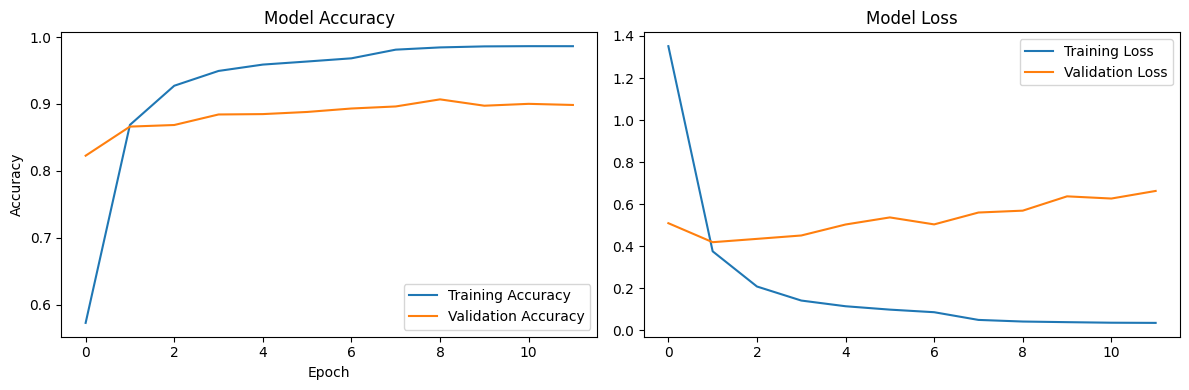

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


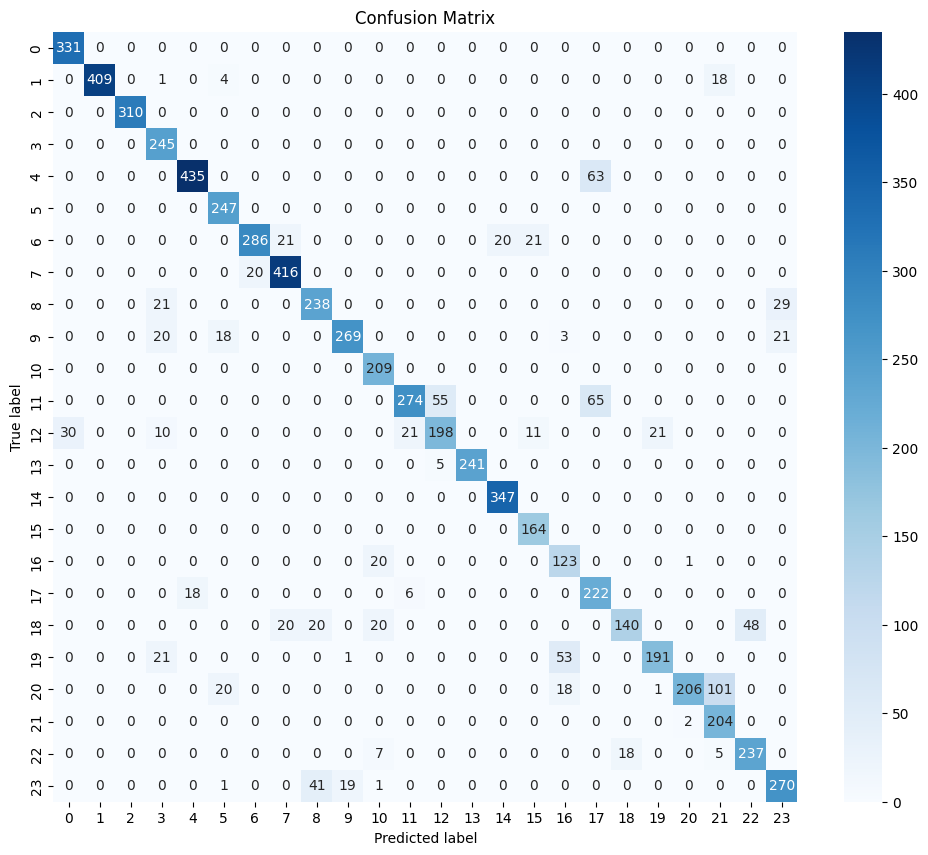

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       331
           1       1.00      0.95      0.97       432
           2       1.00      1.00      1.00       310
           3       0.77      1.00      0.87       245
           4       0.96      0.87      0.91       498
           5       0.85      1.00      0.92       247
           6       0.93      0.82      0.87       348
           7       0.91      0.95      0.93       436
           8       0.80      0.83      0.81       288
          10       0.93      0.81      0.87       331
          11       0.81      1.00      0.90       209
          12       0.91      0.70      0.79       394
          13       0.77      0.68      0.72       291
          14       1.00      0.98      0.99       246
          15       0.95      1.00      0.97       347
          16       0.84      1.00      0.91       164
          17       0.62      0.85      0.72       144
          18       0.63    

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

In [28]:
model.save('cnn_model.h5')
print("Modellen har sparats som 'cnn_model.keras'")

Modellen har sparats som 'cnn_model.keras'


In [27]:
model_loaded = load_model('cnn_model.keras')
print("Model loaded successfully!")

Model loaded successfully!
